In [ ]:
import logging

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.linear_ts_bandit import LinearTSBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [2]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

7
58000


In [3]:
train_loader = DataLoader(Subset(dataset, range(5000)), batch_size=32, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)
bandit_module = LinearTSBandit(
    n_features=dataset.context_size * dataset.num_actions,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="linear_bandit", flush_logs_every_n_steps=100))

In [ ]:
for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1, logger=logger, log_every_n_steps=1, enable_progress_bar=False, enable_model_summary=False
    )
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    logger.pre_training_log({"regret": batch_regret.sum().item()})

    batch_dataloader = DataLoader(feedback, batch_size=1)
    trainer.fit(bandit_module, batch_dataloader)

Step: 31 {'training_run': 0, 'reward': 0.0, 'epoch': 0}'regret': 26.0}

c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Step: 4843 {'training_run': 156, 'reward': 1.0, 'epoch': 0} 'regret': 0.0}

In [ ]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:5000])
cumulative_regret = np.cumsum(metrics["regret"][:5000].dropna())

logs\linear_bandit\version_0/metrics.csv


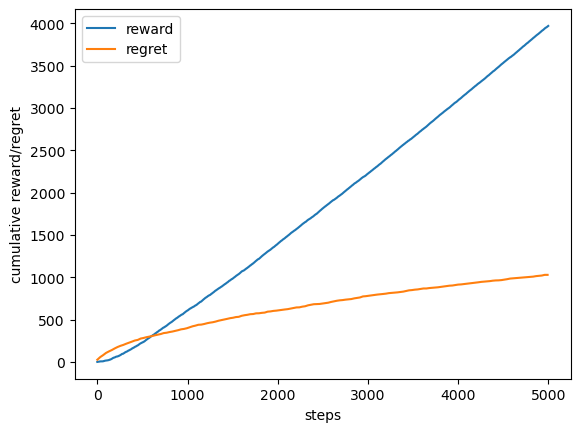

In [6]:
import matplotlib.pyplot as plt

plt.plot(cumulative_reward, label="reward")
plt.plot(cumulative_regret, label="regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [7]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:1000].dropna()) / 1000)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.17
0.608
0.3971
1.06
0.398
0.1029
